# ImageJ with Python Kernel

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including [NumPy](https://www.numpy.org/), [SciPy](https://www.scipy.org/), [scikit-image](https://scikit-image.org/), [CellProfiler](https://cellprofiler.org/), [OpenCV](https://opencv.org/), [ITK](https://itk.org/) and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the [other notebooks](../ImageJ-Tutorials-and-Demo.ipynb).

## Starting ImageJ from Python

The [pyimagej](https://pypi.org/project/pyimagej/) module enables access to the entire ImageJ API from Python in a natural way.

Let's initialize an ImageJ gateway including Fiji plugins, at a reproducible version:

In [1]:
import imagej
ij = imagej.init('sc.fiji:fiji:2.0.0-pre-10')
ij.getVersion()

'2.0.0-rc-71/1.52i'

Here are some other ways to initialize ImageJ:

### Newest available version of ImageJ
```python
ij = imagej.init()
```

### Reproducible version of ImageJ
```python
ij = imagej.init('net.imagej:imagej:2.0.0-rc-71')
```

### With a graphical user interface
```python
ij = imagej.init(headless=False)
ij.ui().showUI()
```

### Including support for ImageJ 1.x
```python
ij = imagej.init('net.imagej:imagej+net.imagej:imagej-legacy')
```

### With Fiji plugins
```python
ij = imagej.init('sc.fiji:fiji')
```

### From a local installation
```python
ij = imagej.init('/Applications/Fiji.app')
```

TODO - explain init syntax(es)
Link to jgo? https://github.com/scijava/jgo

## A simple example

Import an image with scikit-image:

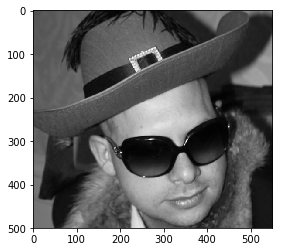

In [2]:
from skimage import io
import numpy as np
img = io.imread('https://samples.fiji.sc/new-lenna.jpg')
img = np.mean(img[500:1000,300:850], axis=2)
ij.py.show(img, cmap='gray')

Compute a difference of Gaussians using [ImageJ Ops](2-ImageJ-Ops.ipynb):

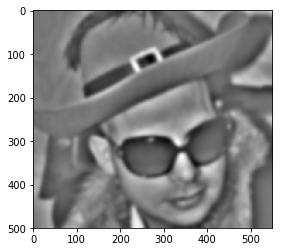

In [3]:
result = np.zeros(img.shape)
sigma1 = 20
sigma2 = 4
ij.op().filter().dog(
    ij.py.to_java(result),
    ij.py.to_java(img),
    sigma1,
    sigma2)
ij.py.show(result, cmap='gray')

## Utility functions in ij.py
pyImageJ comes with a series of helper functions that help convert between Java and Python, make scripting and plugins easy to run, and a quick 2D plotting function.

In [4]:
help(ij.py)

Help on ImageJPython in module imagej.imagej object:

class ImageJPython(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, ij)
 |  
 |  dims(self, image)
 |      Return the dimensions of the equivalent numpy array for the image.  Reverse dimension order from Java.
 |  
 |  from_java(self, data)
 |      Converts the data into a python equivalent
 |  
 |  new_numpy_image(self, image)
 |      Creates a numpy image (NOT a Java image)
 |      dimensioned the same as the given image.
 |  
 |  rai_to_numpy(self, rai)
 |      Convert a RandomAccessibleInterval into a numpy array
 |  
 |  run_macro(self, macro, args=None)
 |      Run an ImageJ1 style macro script
 |      :param macro: The macro code
 |      :param args: Arguments for the script as a dictionary of key/value pairs
 |      :return:
 |  
 |  run_plugin(self, plugin, args=None, ij1_style=True)
 |      Run an ImageJ plugin
 |      :param plugin: The string name for the plugin command
 |      :param args: A dict of ma

The functions `to_java` and `to_python` are capable of handling common data types.  Their is one important nuance; converting a numpy array to java creates a java object that points to the numpy array.  This means that changing the java object also changes the numpy array.

In [5]:
# Lists convert and handle simply
ex_list = [1, 2, 3, 4]
print(type(ex_list))
java_list = ij.py.to_java(ex_list)
print(type(java_list))

<class 'list'>
<class 'jnius.reflect.java.util.ArrayList'>


A java list can be accessed the same as a python list. Changing values in the python list does not change values in the java_list

In [6]:
ex_list[0] = 4
java_list[0]

1

By contrast, ops can operate on numpy arrays and change them, though you need to wrap the arrays in `to_java` first.

In [7]:
import numpy as np
arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5, 6], [7, 8]])
arr_output = ij.py.new_numpy_image(arr1)

ij.op().run('multiply', ij.py.to_java(arr_output), ij.py.to_java(arr1), ij.py.to_java(arr2))
arr_output

array([[ 5., 12.],
       [21., 32.]])

### Technical note for using ops on numpy arrays
Numpy arrays become `RandomAccessibleInterval`s and can substitute for `IterableInterval`s. 

In [8]:
print(type(ij.py.to_java(arr1)))

<class 'jnius.reflect.net/imglib2/python/ReferenceGuardingRandomAccessibleInterval'>


If you need to trouble shoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

In [9]:
# Print is required to render newlines
print(ij.op().help('multiply'))

Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyShort(
		ArrayImg arg,
		short value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedLong(
		ArrayImg arg,
		long value)
	(Arr

## Process numpy arrays in IJ

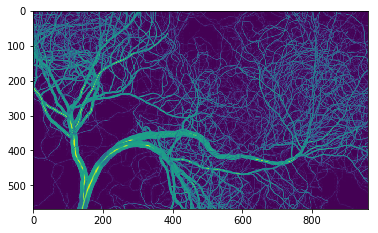

In [10]:
# Import an image with scikit-image.
# NB: Blood vessel image from: https://www.fi.edu/heart/blood-vessels
from skimage import io
url = 'https://www.fi.edu/sites/fi.live.franklinds.webair.com/files/styles/featured_large/public/General_EduRes_Heart_BloodVessels_0.jpg'
img = io.imread(url)
img = np.mean(img, axis=2)
ij.py.show(img)

Ops can take converted numpy arrays as inputs and modify them.  Fill the following cell to call the IJ Frangi vesselness op and display the resulting image.

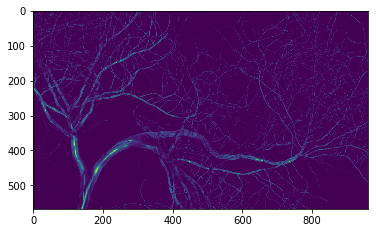

In [11]:
# Create a blank numpy image of the same size as the input
vessels = ij.py.new_numpy_image(img)

# Call the IJ frangiVesselness op with these inputs: ({Output image} , {Input image}, [1, 1], 20)
ij.op().filter().frangiVesselness(ij.py.to_java(vessels), ij.py.to_java(img), [1, 1], 20)

# Display the image
ij.py.show(vessels)

## Send an ImageJ image into NumPy

Open an image from the url using the IJ scripting interface and then send it to a numpy array.

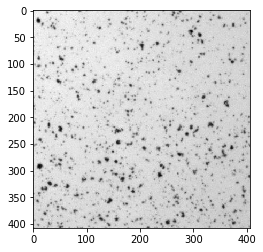

In [12]:
url_colony = 'https://wsr.imagej.net/images/Cell_Colony.jpg'

# Load the image
cell_colony = ij.io().open(url_colony)

# Send it to numpy
numpy_colony = ij.py.from_java(cell_colony)

# Display the image
ij.py.show(numpy_colony, cmap='gray')

### Warning: RGB and other axis conventions must be handled manually

Numpy is reverse indexed from ImageJ, e.g. axis order in numpy is ZYX and in ImageJ is (by default) XYZ.  In addition, numpy and matplotlib have alimited understanding of axis conventions and only natively handle 3-channel RGB images as YXC.  However, conversion between numpy and ImageJ is currently handled by simply reversing the axis order, so taking an ImageJ RGB -> numpy needs an additional step to plot correctly.

A future update will add ways of handling this using pyimagej, but this is currently in the hands of the user.

## Load and display an RGB image from ImageJ

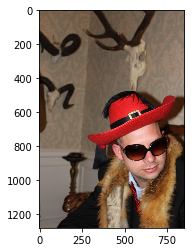

In [13]:
# Show the final image by loading and plotting it from the Scikit-image library
rgb_url = 'http://samples.fiji.sc/new-lenna.jpg'
img_from_skimage = io.imread(rgb_url)
ij.py.show(img_from_skimage)

### Fix these cells so that it loads the image using ImageJ and plots it correctly

In [14]:
# load the image into IJ
ij_img = ij.io().open(rgb_url)

# Convert the image to a numpy array
img_from_ij = ij.py.from_java(ij_img)

np.shape(img_from_ij)

(3, 1279, 853)

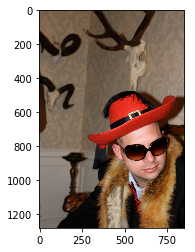

In [15]:
# Hint: There are two barriers to plotting the image: the axis order, and that matplotlib only plot 8-bit RGB images
# Convert to 8-bit
img_as_8bit = img_from_ij.astype(int)

# Fix the axis order
img_as_rgb = np.moveaxis(img_as_8bit, 0, -1)

# Plot the image
ij.py.show(img_as_rgb)

## Running macros, scripts, and plugins

### Using ImageJ macros
Running an IJ1 style macro is as simple as providing the macro code in a string, and the arguments in a dictionary to `run_macro`. Modify the following cell to print your name, age, and city.

In [16]:
macro = """
#@ String name
#@ int age
#@ String city
#@output Object greeting
greeting = "Hello " + name + ". You are " + age + " years old, and live in " + city + "."
"""
args = {
    'name': 'Chuckles',
    'age': 13,
    'city': 'Nowhere'
}
result = ij.py.run_macro(macro, args)
print(result.getOutput('greeting'))

Hello Chuckles. You are 13 years old, and live in Nowhere.


Running scripts in other languages is similar, but you also have to specify the file extension for the scripting language it is written in.

In [17]:
language_extension = 'ijm'
result_script = ij.py.run_script(language_extension, macro, args)
print(result_script.getOutput('greeting'))

Hello Chuckles. You are 13 years old, and live in Nowhere.


### Example: Run a plugin
Finally, running plugins works in the same manner as macros.  You simply enter the plugin name as a string and the arguments in a dict.  For the few plugins that use IJ2 style macros (i.e., explicit booleans in the recorder), set the optional variable `ij1_style=False`

This example works with IJ1 windows, opening images entirely within IJ and then getting the results.  Working with IJ1 windows requires importing another class, which is done using the jnius framework.  The jnius.autoclass function can import other java classes for similar purposes.

In [18]:
from jnius import autoclass
WindowManager = autoclass('ij.WindowManager')
ij.py.run_macro("""run("Blobs (25K)");""")
blobs = WindowManager.getCurrentImage()
print(blobs)

<ij.ImagePlus at 0x122874a40 jclass=ij/ImagePlus jself=<LocalRef obj=0x7facc9560528 at 0x647efbb70>>


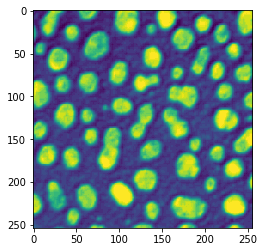

In [19]:
ij.py.show(blobs)

We can now run plugins that require open IJ1 windows on blobs

In [20]:
plugin = 'Mean'
args = { 
    'block_radius_x': 10,
    'block_radius_y': 10
}

ij.py.run_plugin(plugin, args)

<org.scijava.script.ScriptModule at 0x6485126d0 jclass=org/scijava/script/ScriptModule jself=<LocalRef obj=0x7faccdc5a070 at 0x6477e61d0>>

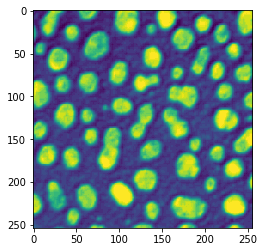

In [21]:
result = WindowManager.getCurrentImage()
result = ij.py.show(result)

You can list any active IJ1 windows with the following command.

In [22]:
print(ij.py.from_java(ij.window().getOpenWindows()))

['blobs.gif']


You can close any IJ1 windows through the following command.

In [23]:
ij.window().clear()
print(ij.py.from_java(ij.window().getOpenWindows()))

[]


## Visualizing large images

Before we begin: how much memory is Java using right now?

In [24]:
from jnius import autoclass
Runtime = autoclass('java.lang.Runtime')
def java_mem():
    rt = Runtime.getRuntime()
    mem_max = rt.maxMemory()
    mem_used = rt.totalMemory() - rt.freeMemory()
    return '{} of {} MB ({}%)'.format(
        int(mem_used / 2**20),
        int(mem_max / 2**20),
        int(100 * mem_used / mem_max))
java_mem()

'180 of 3641 MB (4%)'

Now let's open an obnoxiously huge synthetic dataset:

In [25]:
from jnius import autoclass
SCIFIOConfig = autoclass('io.scif.config.SCIFIOConfig')
ImgMode = autoclass('io.scif.config.SCIFIOConfig$ImgMode')
config = SCIFIOConfig().imgOpenerSetImgModes(ImgMode.CELL)
big_data = ij.scifio().datasetIO().open('lotsofplanes&lengths=512,512,16,1000,10000&axes=X,Y,Channel,Z,Time.fake', config)

How many total samples does this image have?

In [26]:
import numpy as np
dims = [big_data.dimension(d) for d in range(big_data.numDimensions())]
pix = np.prod(dims)
str(pix / 2**40) + " terapixels"

'38.14697265625 terapixels'

And how much did memory usage in Java increase?

In [27]:
java_mem()

'950 of 3641 MB (26%)'

Let's visualize this beast. First, we define a function for slicing out a single plane:

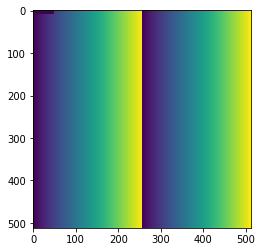

In [28]:
def plane(image, pos):
    while image.numDimensions() > 2:
        image = ij.op().transform().hyperSliceView(image, image.numDimensions() - 1, pos[-1])
        pos.pop()
    return ij.py.from_java(image)

ij.py.show(plane(big_data, [0, 0, 0]))

But we can do better. Let's provide some interaction. First, a function to extract the _non-planar_ axes as a dict:

In [29]:
from jnius import autoclass, cast
CalibratedAxis = autoclass('net.imagej.axis.CalibratedAxis')

def axes(dataset):
    axes = {}
    for d in range(2, dataset.numDimensions()):
        axis = cast(CalibratedAxis, dataset.axis(d))
        label = axis.type().getLabel()
        length = dataset.dimension(d)
        axes[label] = length
    return axes

axes(big_data)

{'Channel': 16, 'Z': 1000, 'Time': 10000}

And now, we have the tools we need to use `ipywidgets.interact` for any N-dimensional image!

In [30]:
import ipywidgets, matplotlib

widgets = {}
for label, length in axes(big_data).items():
    widgets[label] = ipywidgets.IntSlider(description=label, max=length-1)

def f(**kwargs):
    matplotlib.pyplot.imshow(plane(big_data, list(kwargs.values())), cmap='gray')
ipywidgets.interact(f, **widgets);

interactive(children=(IntSlider(value=0, description='Channel', max=15), IntSlider(value=0, description='Z', m…